In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from lab7_cmd_types import CMD
import time
import numpy as np
LOG.propagate = False
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-03-23 22:04:26,435 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64
2025-03-23 22:04:29,640 | INFO     |: Connected to c0:81:04:26:a3:64


In [82]:
ble.disconnect()

2025-03-23 21:56:18,777 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [94]:
ble.send_command(CMD.PING, "")
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [95]:
ble.send_command(CMD.START_STEP, "")

In [23]:
ble.send_command(CMD.STOP_STEP, "")

In [96]:
results = []


def notification_handler(uuid, byte_array):
    # Parse the data string from Arduino
    # Format: time | distance | velocity
    time_val, pwm, distance_val, velocity_val = ble.bytearray_to_string(
        byte_array).split('|')

    # Convert to appropriate types and store
    results.append([float(time_val), int(pwm), float(distance_val), float(velocity_val)])


# ble.stop_notify(ble.uuid['RX_STRING'])  # Optional: stop previous notifications
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.COLLECT_DATA, "")

In [97]:
print(results)

[[25626.0, 0, 180.0, 0.0], [25684.0, 0, 185.0, 86.206], [25698.0, 0, 169.0, -1142.857], [25807.0, 100, 172.0, 27.522], [25922.0, 100, 184.0, 104.347], [26029.0, 100, 178.0, -56.074], [26138.0, 100, 172.0, -55.045], [26365.0, 100, 160.0, -52.863], [26420.0, 100, 166.0, 109.09], [26560.0, 100, 166.0, 0.0], [26739.0, 100, 186.0, 111.731], [26802.0, 100, 185.0, -15.873], [27126.0, 100, 164.0, -64.814], [27364.0, 100, 176.0, 50.42], [27543.0, 100, 202.0, 145.251], [27833.0, 100, 189.0, -44.827], [27911.0, 100, 192.0, 38.461], [28140.0, 100, 219.0, 117.903], [28301.0, 100, 277.0, 360.248], [28436.0, 100, 302.0, 185.185], [28733.0, 100, 225.0, -259.259], [28883.0, 100, 146.0, -526.666], [28899.0, 100, 94.0, -3249.999], [28997.0, 100, 55.0, -397.959], [29113.0, 100, 80.0, 215.517], [29184.0, 100, 88.0, 112.676], [29259.0, 100, 94.0, 80.0], [29275.0, 100, 84.0, -625.0], [29305.0, 100, 88.0, 133.333], [29448.0, 100, 85.0, -20.979], [29586.0, 100, 84.0, -7.246], [29655.0, 0, 74.0, -144.927], [296

In [99]:
ble.stop_notify(ble.uuid['RX_STRING'])

Exception: Not connected to a BLE device

In [91]:
import csv
import datetime

# Generate filename with timestamp to avoid overwriting
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"robot_data_{timestamp}.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Time (ms)', 'Distance (mm)', 'Velocity (mm/s)'])
    # Write all data rows
    csvwriter.writerows(results)

print(f"Data saved to {filename}")

Data saved to robot_data_20250323_220200.csv


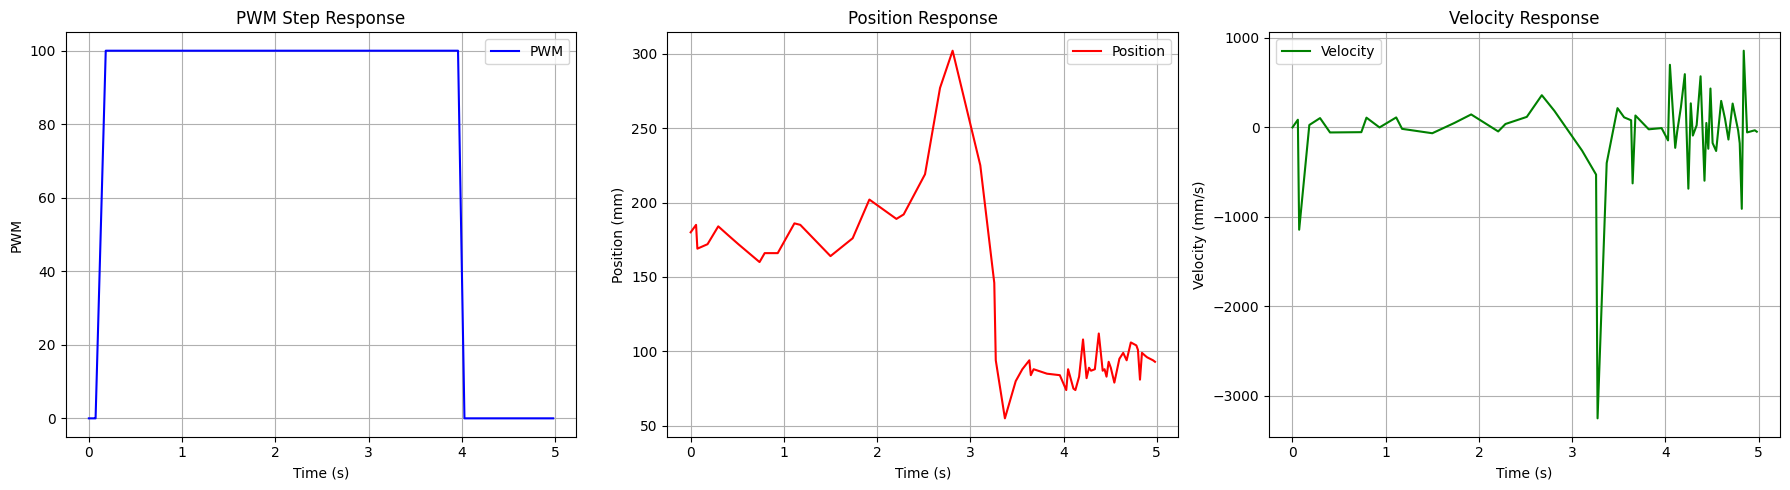

In [103]:
# Now create the plots
# Convert results to numpy array for easier handling
data = np.array(results)
time_ms = data[:, 0]
pwm = data[:, 1]
distance = data[:, 2]
velocity = data[:, 3]

# Convert time to seconds
# Normalize to start at 0 and convert to seconds
time_s = (time_ms - time_ms[0]) / 1000.0

# Create figure with three subplots in a row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot PWM vs Time
ax1.plot(time_s, pwm, 'b-', label='PWM')
ax1.set_ylabel('PWM')
ax1.set_xlabel('Time (s)')
ax1.set_title('PWM Step Response')
ax1.grid(True)
ax1.legend()

# Plot Position (Distance) vs Time
ax2.plot(time_s, distance, 'r-', label='Position')
ax2.set_ylabel('Position (mm)')
ax2.set_xlabel('Time (s)')
ax2.set_title('Position Response')
ax2.grid(True)
ax2.legend()

# Plot Velocity vs Time
ax3.plot(time_s, velocity, 'g-', label='Velocity')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Velocity (mm/s)')
ax3.set_title('Velocity Response')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()